In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from tqdm import tqdm
import re

from collections import Counter
from collections import defaultdict

In [2]:
#df_copy = pd.read_csv('data/stage_3_df_100s_50p_5.csv')
df_copy = pd.read_csv('data/stage_3_df_cluster_vac_to_model_4.csv')
#df_copy = pd.read_csv('data/stage_3_df_ru_region_skills_new_to_model.csv')
#df_copy = pd.read_csv('data/stage_3_df_ru_region_to_model.csv')
#df_copy = pd.read_csv('data/stage_3_df_to_model.csv')

In [3]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14975 entries, 0 to 14974
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   position                  14975 non-null  object 
 1   date                      14975 non-null  object 
 2   vacancy                   14975 non-null  object 
 3   company                   14975 non-null  object 
 4   city                      14975 non-null  object 
 5   experience                14975 non-null  object 
 6   employment                14975 non-null  object 
 7   schedule                  14975 non-null  object 
 8   salary from               14975 non-null  float64
 9   salary to                 14975 non-null  float64
 10  currency                  14968 non-null  object 
 11  skills                    14975 non-null  object 
 12  url                       14975 non-null  object 
 13  ID                        14975 non-null  float64
 14  countr

In [4]:
df_copy = df_copy.drop(['industry','level_copy', 'is_it','skills_list', 'skills_clean',
                        'skills_llm','vacancy_info','experience level','contact', 'contacts', 'education', 'benefits', 
                        'requirements', 'responsibilities', 'period of pay', 'text',
                        'ID', 'url', 'skills_count','currency', 'skills_new', 'vacancy_norm'], axis = 1)

In [5]:
'''df_copy['level_merged'] = df_copy['level'].replace({
    'Lead': 'Lead/Senior',
    'Senior': 'Lead/Senior'
})'''

"df_copy['level_merged'] = df_copy['level'].replace({\n    'Lead': 'Lead/Senior',\n    'Senior': 'Lead/Senior'\n})"

In [6]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14975 entries, 0 to 14974
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   position                  14975 non-null  object 
 1   date                      14975 non-null  object 
 2   vacancy                   14975 non-null  object 
 3   company                   14975 non-null  object 
 4   city                      14975 non-null  object 
 5   experience                14975 non-null  object 
 6   employment                14975 non-null  object 
 7   schedule                  14975 non-null  object 
 8   salary from               14975 non-null  float64
 9   salary to                 14975 non-null  float64
 10  skills                    14975 non-null  object 
 11  country                   14975 non-null  object 
 12  level                     14975 non-null  object 
 13  skills_clean_norm         14975 non-null  object 
 14  vacanc

In [7]:
df_copy['skills_processed']

0        ['Проектирование и реализация архитектур хране...
1        ['SQL Oracle, MSSQL, PostgreSQL', 'Google Apps...
2        ['Системы управления проектами', 'Python panda...
3        ['Системы управления проектами', 'Python panda...
4        ['Системы управления проектами', 'Python panda...
                               ...                        
14970    ['Консультирование клиентов', 'Подбор оборудов...
14971    ['Работа с ПК', 'Разработка технических схем',...
14972    ['Сетевые протоколы TCP/IP', 'Системы монитори...
14973    ['CRM 1C', 'Управленческий учёт 1С', 'RESTapi'...
14974    ['AutoCad/NanoCad', 'Градостроительный кодекс ...
Name: skills_processed, Length: 14975, dtype: object

In [8]:
df_copy['skills']

0        ['Python', 'SQL (PostgreSQL, SQLite)', 'проект...
1        ['Python (pandas, scipy)', 'SQL', 'HTML (CSS)'...
2        ['Power BI', 'Python', 'SQL', 'Excel', 'Power ...
3        ['Power BI', 'Python', 'SQL', 'Excel (Power Qu...
4        ['Power BI', 'Python', 'SQL', 'Excel (Power Qu...
                               ...                        
14970                                 Деловая коммуникация
14971    Работа с ПК, MS Office, Разработка технических...
14972    TCP/IP, DNS, DHCP, Разработка технической доку...
14973    ['Управленческий учёт (1С)', 'ERP-системы (1С)...
14974    ['AutoCad/NanoCad', 'Нормативно-техническая ба...
Name: skills, Length: 14975, dtype: object

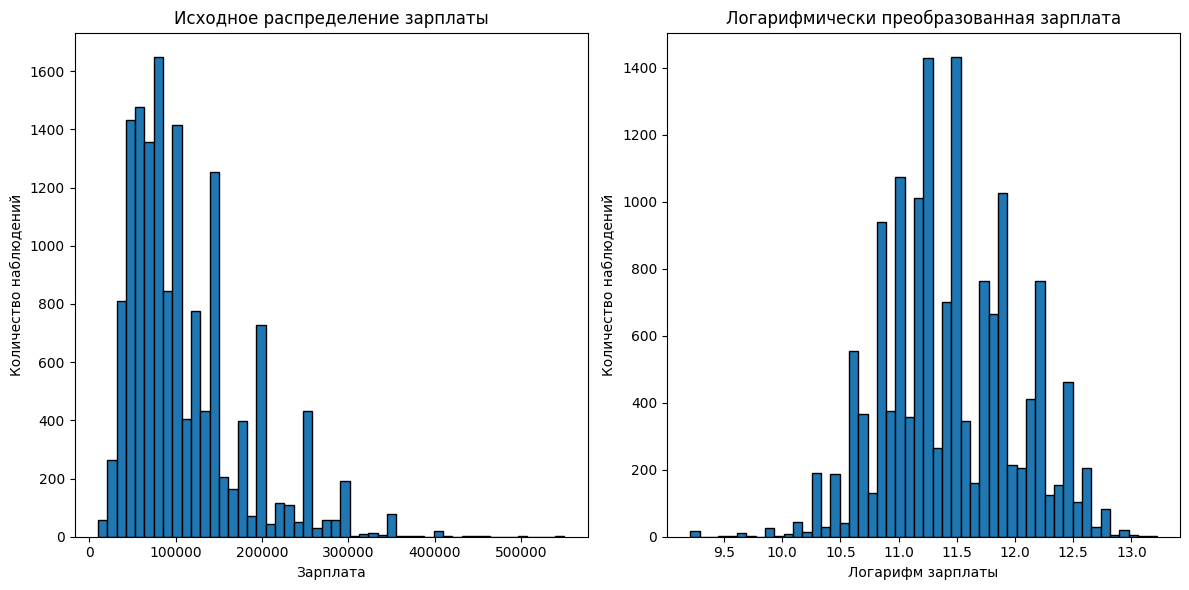

In [9]:
# Готовим данные
original_salary = df_copy['salary from norm']
transformed_salary = np.log1p(original_salary)

# Создаем два subplot'a
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Левый график: исходное распределение
axes[0].hist(original_salary, bins=50, edgecolor='k')
axes[0].set_title('Исходное распределение зарплаты')
axes[0].set_xlabel('Зарплата')
axes[0].set_ylabel('Количество наблюдений')

# Правый график: логарифмически преобразованное распределение
axes[1].hist(transformed_salary, bins=50, edgecolor='k')
axes[1].set_title('Логарифмически преобразованная зарплата')
axes[1].set_xlabel('Логарифм зарплаты')
axes[1].set_ylabel('Количество наблюдений')

# Автоподгонка расположения графиков
plt.tight_layout()

# Показываем графики
plt.show()

In [10]:
# а попробуем самый простой вариант группировки вакансий 
'''
# Преобразуем list в tuple для правильной группировки
df_copy['skills_tuple'] = df_copy['skills_processed'].map(tuple)

# Группируем сначала по position, затем по unique skill sets
grouped = df_copy.groupby(['position', 'skills_tuple'])

# Функция для выбора самого популярного vacancy_it
def select_most_frequent_vacancy(g):
    counts = g['vacancy it'].value_counts()
    
    # Если несколько вакансий имеют максимальную частоту, выбираем самую короткую
    max_freq = counts.max()
    filtered = counts[counts == max_freq]
    if len(filtered) > 1:
        return sorted(filtered.index, key=lambda x: len(x))[0]
    else:
        return filtered.index[0]

# Применяем функцию для каждого уровня группировки
result = grouped.apply(select_most_frequent_vacancy).rename('vacancy_union').reset_index()

# Возвращаемся обратно к оригинальной структуре (если нужно)
df_copy = df_copy.merge(result, how='left', on=['position', 'skills_tuple'])

# Удаляем промежуточный столбец
df_copy.drop(columns=['skills_tuple'], inplace=True)

'''

"\n# Преобразуем list в tuple для правильной группировки\ndf_copy['skills_tuple'] = df_copy['skills_processed'].map(tuple)\n\n# Группируем сначала по position, затем по unique skill sets\ngrouped = df_copy.groupby(['position', 'skills_tuple'])\n\n# Функция для выбора самого популярного vacancy_it\ndef select_most_frequent_vacancy(g):\n    counts = g['vacancy it'].value_counts()\n    \n    # Если несколько вакансий имеют максимальную частоту, выбираем самую короткую\n    max_freq = counts.max()\n    filtered = counts[counts == max_freq]\n    if len(filtered) > 1:\n        return sorted(filtered.index, key=lambda x: len(x))[0]\n    else:\n        return filtered.index[0]\n\n# Применяем функцию для каждого уровня группировки\nresult = grouped.apply(select_most_frequent_vacancy).rename('vacancy_union').reset_index()\n\n# Возвращаемся обратно к оригинальной структуре (если нужно)\ndf_copy = df_copy.merge(result, how='left', on=['position', 'skills_tuple'])\n\n# Удаляем промежуточный столбец

In [11]:
#display(df_copy['vacancy it'].nunique())
#display(df_copy['vacancy_union'].nunique())

In [12]:
# подготовка данных к обучению

df_train_result = df_copy[(df_copy['country'] == 'Россия') ][['salary from norm',
                                                              'salary to norm', 
                                                              'position', 
                                                              'experience_norm', 
                                                               'skills_processed', # 'skills_clean_norm','skills_processed, 'skills_manu'
                                                              'schedule','employment', 'vacancy it',
                                                               #'vacancy_norm_llm_check_1', 'vacancy it','vacancy_manu','vacancy_norm_2', 'vacancy_manu'
                                                              'level',
                                                              'region']]

df_train_result = df_train_result.dropna(subset=['salary from norm', 'salary to norm'], how='any') # 

df_train_result.rename(columns={'skills_processed': 'skills',
                                'experience_norm':'experience',
                                'vacancy it':'vacancy'}, inplace=True)

df_train_result['skills'] = df_train_result['skills'].apply(literal_eval)

df_train_result.rename(columns={
    'salary from norm': 'salary from',
    'salary to norm': 'salary to'
}, inplace=True)

##### Важно ! Предыдущий дата сет лучше с vacancy it, skills_processed , > 50 на регионах и > 550 position 

In [13]:
df_train_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14975 entries, 0 to 14974
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   salary from  14975 non-null  float64
 1   salary to    14975 non-null  float64
 2   position     14975 non-null  object 
 3   experience   14975 non-null  object 
 4   skills       14975 non-null  object 
 5   schedule     14975 non-null  object 
 6   employment   14975 non-null  object 
 7   vacancy      14975 non-null  object 
 8   level        14975 non-null  object 
 9   region       14975 non-null  object 
dtypes: float64(2), object(8)
memory usage: 1.1+ MB


In [14]:
df_copy['vacancy it'].value_counts(dropna=False)

vacancy it
Системный администратор                                      881
Программист 1С                                               561
Специалист технической поддержки                             486
Графический дизайнер                                         273
Инженер технической поддержки                                164
                                                            ... 
Технический директор производства декораций                    1
Помощник SEO-оптимизатора                                      1
Cпециалист по сертификации                                     1
Технический специалист в отдел мотор-редукторов                1
Эксперт-проектировщик сетей водоснабжения и водоотведения      1
Name: count, Length: 6944, dtype: int64

In [15]:
df_train_result = df_train_result[df_train_result['vacancy'] != 'trash']

In [16]:
mask = df_train_result['region'].value_counts() >= 50 # 100
df_train_result = df_train_result[df_train_result['region'].isin(mask[mask].index)]

In [17]:
df_train_result['region'].value_counts()

region
Москва                     4907
Санкт-Петербург            1994
Свердловская область        561
Краснодарский край          526
Республика Татарстан        491
Новосибирская область       441
Московская область          397
Нижегородская область       357
Ростовская область          339
Воронежская область         309
Самарская область           252
Челябинская область         251
Красноярский край           219
Приморский край             215
Пермский край               209
Башкортостан                198
Ярославская область         193
Волгоградская область       157
Тульская область            148
Томская область             127
Тюменская область           121
Омская область              120
Иркутская область           116
Алтайский край              114
Рязанская область           106
Кемеровская область         105
Хабаровский край            104
Чувашская Республика        104
Саратовская область         103
Калининградская область     100
Удмуртская Республика        98
Р

In [18]:
df_train_result['level'].value_counts()

level
Unknown    12431
Junior       680
Middle       634
Senior       254
Trainee      171
Lead          76
Chief          7
Name: count, dtype: int64

In [19]:
df_train_result['experience'].value_counts()

experience
1–3 года       7849
3–6 лет        3496
Нет опыта      2514
Более 6 лет     394
Name: count, dtype: int64

In [20]:
# Проводим логарифмическое преобразование целевой переменной если лучше mae
#df_train_result['log_salary'] = np.log1p(df_train_result['salary from'])

In [21]:
df_train_result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14253 entries, 0 to 14974
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   salary from  14253 non-null  float64
 1   salary to    14253 non-null  float64
 2   position     14253 non-null  object 
 3   experience   14253 non-null  object 
 4   skills       14253 non-null  object 
 5   schedule     14253 non-null  object 
 6   employment   14253 non-null  object 
 7   vacancy      14253 non-null  object 
 8   level        14253 non-null  object 
 9   region       14253 non-null  object 
dtypes: float64(2), object(8)
memory usage: 1.2+ MB


In [22]:
def filtered_skills_top_n(df_train_result, n):
    """
    Фильтрует навыки, оставляя только N наиболее популярных навыков для каждой позиции.
    
    :param df_skills_filtered: Входящий DataFrame с колонками 'position' и 'skills'.
    :param n: Число наиболее популярных навыков, которое нужно оставить.
    :return: Отфильтрованный DataFrame с сокращённым списком навыков.
    """
    
    result_df = df_train_result.copy()
    #display(result_df['skills'])
    # Перебираем каждую уникальную должность
    for pos in result_df['position'].unique():
        # Маска для выбора строк с нужной должностью
        mask = result_df['position'] == pos
        
        # Собираем все навыки в один большой список
        skills_lists = result_df.loc[mask, 'skills']
        all_skills = [skill for sublist in skills_lists for skill in sublist]
        
        # Считаем частоту появления каждого навыка
        skill_counts = Counter(all_skills)
        
        # Берём топ-n навыков
        top_n_skills = set([skill for skill, _ in skill_counts.most_common(n)])
        
        # Применяем фильтр к списку навыков
        result_df.loc[mask, 'skills'] = skills_lists.apply(
            lambda skill_list: [s for s in skill_list if s in top_n_skills]
        )
        #display(result_df['skills'])
    return result_df

In [23]:
from scipy.stats import normaltest

# Функция очистки и нормализации
def process_series(series, colname, position):
    series = pd.to_numeric(series, errors='coerce')
    series = series.dropna()
    n_total = len(series)


    stat, p = normaltest(series)
    is_normal = p > 0.05

    if is_normal:
        mu, sigma = series.mean(), series.std()
        mask = (series >= mu - 3 * sigma) & (series <= mu + 3 * sigma)
    else:
        q1 = series.quantile(0.25)
        q3 = series.quantile(0.75)
        iqr = q3 - q1
        mask = (series >= q1 - 1.5 * iqr) & (series <= q3 + 1.5 * iqr)

    n_filtered = mask.sum()
    n_removed = n_total - n_filtered


    return series[mask]

Top-N Skills:   0%|          | 0/4 [00:00<?, ?it/s]

' Взяли 20 скилов . Осталось 8681 cтрок в df. Всего уникальных 400'

C:\Users\Андрей\AppData\Local\Temp\ipykernel_4252\2136363346.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 40 вакансий . Осталось 4700 cтрок в df'

'После исключения позиций с < 200 строк осталось 2662 строк и 4 позиций'

C:\Users\Андрей\AppData\Local\Temp\ipykernel_4252\2136363346.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 50 вакансий . Осталось 4950 cтрок в df'

'После исключения позиций с < 200 строк осталось 2773 строк и 4 позиций'

C:\Users\Андрей\AppData\Local\Temp\ipykernel_4252\2136363346.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 70 вакансий . Осталось 5340 cтрок в df'

'После исключения позиций с < 200 строк осталось 2953 строк и 4 позиций'

C:\Users\Андрей\AppData\Local\Temp\ipykernel_4252\2136363346.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 100 вакансий . Осталось 5788 cтрок в df'

'После исключения позиций с < 200 строк осталось 3163 строк и 4 позиций'

Top-N Skills:  25%|██▌       | 1/4 [00:04<00:14,  4.88s/it]

' Взяли 30 скилов . Осталось 9566 cтрок в df. Всего уникальных 590'

C:\Users\Андрей\AppData\Local\Temp\ipykernel_4252\2136363346.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 40 вакансий . Осталось 5121 cтрок в df'

'После исключения позиций с < 200 строк осталось 2946 строк и 4 позиций'

C:\Users\Андрей\AppData\Local\Temp\ipykernel_4252\2136363346.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 50 вакансий . Осталось 5394 cтрок в df'

'После исключения позиций с < 200 строк осталось 3068 строк и 4 позиций'

C:\Users\Андрей\AppData\Local\Temp\ipykernel_4252\2136363346.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 70 вакансий . Осталось 5815 cтрок в df'

'После исключения позиций с < 200 строк осталось 3257 строк и 4 позиций'

C:\Users\Андрей\AppData\Local\Temp\ipykernel_4252\2136363346.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 100 вакансий . Осталось 6306 cтрок в df'

'После исключения позиций с < 200 строк осталось 3484 строк и 4 позиций'

Top-N Skills:  50%|█████     | 2/4 [00:10<00:10,  5.07s/it]

' Взяли 50 скилов . Осталось 10574 cтрок в df. Всего уникальных 961'

C:\Users\Андрей\AppData\Local\Temp\ipykernel_4252\2136363346.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 40 вакансий . Осталось 5622 cтрок в df'

'После исключения позиций с < 200 строк осталось 3306 строк и 4 позиций'

C:\Users\Андрей\AppData\Local\Temp\ipykernel_4252\2136363346.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 50 вакансий . Осталось 5917 cтрок в df'

'После исключения позиций с < 200 строк осталось 3441 строк и 4 позиций'

C:\Users\Андрей\AppData\Local\Temp\ipykernel_4252\2136363346.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 70 вакансий . Осталось 6368 cтрок в df'

'После исключения позиций с < 200 строк осталось 3641 строк и 4 позиций'

C:\Users\Андрей\AppData\Local\Temp\ipykernel_4252\2136363346.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 100 вакансий . Осталось 6906 cтрок в df'

'После исключения позиций с < 200 строк осталось 3876 строк и 4 позиций'

Top-N Skills:  75%|███████▌  | 3/4 [00:16<00:05,  5.59s/it]

' Взяли 70 скилов . Осталось 11151 cтрок в df. Всего уникальных 1337'

C:\Users\Андрей\AppData\Local\Temp\ipykernel_4252\2136363346.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 40 вакансий . Осталось 5862 cтрок в df'

'После исключения позиций с < 200 строк осталось 3456 строк и 4 позиций'

C:\Users\Андрей\AppData\Local\Temp\ipykernel_4252\2136363346.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 50 вакансий . Осталось 6168 cтрок в df'

'После исключения позиций с < 200 строк осталось 3596 строк и 4 позиций'

C:\Users\Андрей\AppData\Local\Temp\ipykernel_4252\2136363346.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 70 вакансий . Осталось 6634 cтрок в df'

'После исключения позиций с < 200 строк осталось 3802 строк и 4 позиций'

C:\Users\Андрей\AppData\Local\Temp\ipykernel_4252\2136363346.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 100 вакансий . Осталось 7210 cтрок в df'

'После исключения позиций с < 200 строк осталось 4050 строк и 4 позиций'

Top-N Skills: 100%|██████████| 4/4 [00:23<00:00,  5.75s/it]


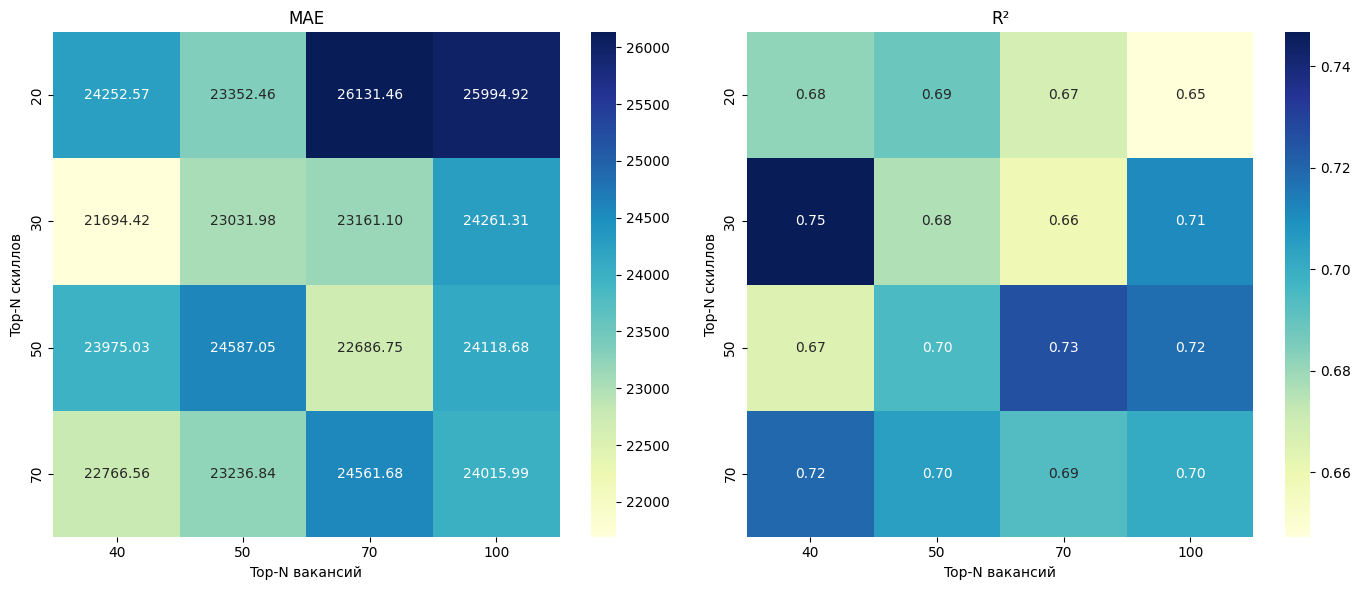

Лучшее сочетание по MAE:
Top Skills: 30.0, Top Vacancies: 40.0, MAE: 21694.42, R²: 0.75


In [24]:


# Параметры
top_skills_range = [ 20, 30, 50, 70]
top_vacancies_range = [40,50,70, 100] # 30, 40 , 50, 70,


results = []

for skill_n in tqdm(top_skills_range, desc="Top-N Skills"):
    df_skills_filtered = filtered_skills_top_n(df_train_result.copy(), skill_n)
    #display(df_skills_filtered['skills'])
    # Удаляем строки с пустыми списками skills
    df_skills_filtered = df_skills_filtered[df_skills_filtered['skills'].apply(lambda x: len(x) > 0)]
    

    def flatten_skills(skills_series):
        all_skills = []
        for skill_list in skills_series:
            if isinstance(skill_list, list):
                all_skills.extend(skill_list)
        return all_skills
    #display(df_skills_filtered['skills'])
    display(f" Взяли {skill_n} скилов . Осталось {df_skills_filtered.shape[0]} cтрок в df. Всего уникальных {len(set(flatten_skills(df_skills_filtered['skills'])))}" )
    for vac_n in top_vacancies_range:
        # Фильтрация вакансий по top-N внутри позиции
        def filter_top_vacancies(group, n=vac_n):
            vac_counts = group['vacancy'].value_counts()
            top_vacancies = vac_counts.head(n).index.tolist()
            #top_vacancies = vac_counts.index.tolist()
            return group[group['vacancy'].isin(top_vacancies)]

        df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)
        display(f" Взяли {vac_n} вакансий . Осталось {df_filtered.shape[0]} cтрок в df")
        
        # Удаляем позиции с количеством строк < 150
        position_counts = df_filtered['position'].value_counts()
        valid_positions = position_counts[position_counts >= 550].index.tolist() # 200

        df_filtered = df_filtered[df_filtered['position'].isin(valid_positions)]

        display(f"После исключения позиций с < 200 строк осталось {df_filtered.shape[0]} строк и {len(valid_positions)} позиций")

        
        
        
        # Обработка целевой переменной и признаков
        df_temp = df_filtered.copy()
        
        
        # Очистка целевой переменной от выбросов
        positions_temp = df_temp['position'].dropna().unique()

        for pos in positions_temp:
            pos_mask = df_temp['position'] == pos
            clean_series = process_series(df_temp.loc[pos_mask, 'salary from'], 'salary from', pos)
            if clean_series is not None:
                df_temp.loc[clean_series.index, 'salary from norm'] = clean_series

        # Удалим строки с NaN после очистки
        df_temp = df_temp.dropna(subset=['salary from norm'])
        
        
        if df_temp.empty:
            continue

        # Целевая переменная после очистки
        y = df_temp['salary from norm']
        
        
        
        if df_temp.empty:
            continue

        X = df_temp[['position', 'experience', 'schedule', 'employment', 'level', 'vacancy', 'skills', 'region']] # 'vacancy it',
        #y = df_temp['log_salary']
        #y = df_temp['salary from']

        ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        mlb = MultiLabelBinarizer()

        try:
            X_ohe = ohe.fit_transform(X[['position', 'experience', 'schedule', 'employment' ,'vacancy', 'level', 'region']]) # , 'vacancy it',
            X_mlb = mlb.fit_transform(X['skills'])
        except Exception as e:
            print(f"Ошибка кодирования при skill_n={skill_n}, vac_n={vac_n}: {e}")
            continue

        X_final = np.hstack([X_ohe, X_mlb])

        try:
            splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
            for train_idx, test_idx in splitter.split(X_final, df_temp['position']):
                X_train, X_test = X_final[train_idx], X_final[test_idx]
                y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        except ValueError as e:
            print(f"Ошибка split при skill_n={skill_n}, vac_n={vac_n}: {e}")
            continue

        rf_model = RandomForestRegressor(
            n_estimators=500, max_depth=100, random_state=42, n_jobs=-1,
            max_features='sqrt', min_samples_leaf=1, min_samples_split=2
        )

        rf_model.fit(X_train, y_train)
        y_pred = rf_model.predict(X_test)
        
        
        #y_pred = np.expm1(y_pred)
        
        #mae = mean_absolute_error(np.expm1(y_test), y_pred)
        #r2 = r2_score(np.expm1(y_test),  y_pred)
        
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test,  y_pred)

        results.append({
            'top_skills': skill_n,
            'top_vacancies': vac_n,
            'mae': mae,
            'r2': r2,
            'rows': len(df_temp)
        })

# Переводим результаты в DataFrame
results_df = pd.DataFrame(results)

# Визуализация результатов
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
pivot_mae = results_df.pivot(index='top_skills', columns='top_vacancies', values='mae')
sns.heatmap(pivot_mae, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('MAE')
plt.xlabel('Top-N вакансий')
plt.ylabel('Top-N скиллов')

plt.subplot(1, 2, 2)
pivot_r2 = results_df.pivot(index='top_skills', columns='top_vacancies', values='r2')
sns.heatmap(pivot_r2, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('R²')
plt.xlabel('Top-N вакансий')
plt.ylabel('Top-N скиллов')

plt.tight_layout()
plt.show()

# Вывод лучшего сочетания
best_row = results_df.sort_values(by='mae').iloc[0]
print(f"Лучшее сочетание по MAE:\nTop Skills: {best_row['top_skills']}, "
      f"Top Vacancies: {best_row['top_vacancies']}, "
      f"MAE: {best_row['mae']:.2f}, R²: {best_row['r2']:.2f}")


Лучшее сочетание по MAE:
Top Skills: 70.0, Top Vacancies: 40.0, MAE: 21666.33, R²: 0.74

Лучшее сочетание по MAE:
Top Skills: 30.0, Top Vacancies: 40.0, MAE: 21694.42, R²: 0.75

200 позишн > 200 регионы 
Лучшее сочетание по MAE:
Top Skills: 70.0, Top Vacancies: 30.0, MAE: 23850.22, R²: 0.67, Строк: 3055.0

150 позишн > 200 регионы 
Лучшее сочетание по MAE:
Top Skills: 30.0, Top Vacancies: 30.0, MAE: 24002.10, R²: 0.66, Строк: 3803.0

150 позишн > 100 регионы  Лучшее сочетание по MAE:
Top Skills: 100.0, Top Vacancies: 30.0, MAE: 25421.98, R²: 0.71, Строк: 6906.0

60 в позишн Лучшее сочетание по MAE:
Top Skills: 50.0, Top Vacancies: 30.0, MAE: 24866.70, R²: 0.67, Строк: 5213.0 (17 позиций)

> 150 в позишн , вакансия ит - Лучшее сочетание по MAE:
Top Skills: 100.0, Top Vacancies: 40.0, MAE: 23944.37, R²: 0.70, Строк: 5245.0

Лучшее сочетание по MAE:
Top Skills: 50.0, Top Vacancies: 30.0, MAE: 26766.35, R²: 0.67, Строк: 5477.

скилы 2 .0  вакансии старые учшее сочетание по MAE:
Top Skills: 20.0, Top Vacancies: 40.0, MAE: 26880.21, R²: 0.65, Строк: 7430.0

Лучшее сочетание по MAE:
Top Skills: 30.0, Top Vacancies: 40.0, MAE: 30224.71, R²: 0.64, Строк: 5850.0

скилы + регионы - лог
Лучшее сочетание по MAE:
Top Skills: 50.0, Top Vacancies: 30.0, MAE: 26860.78, R²: 0.67, Строк: 5206.0

со скилами из ллм + регионы + log
Лучшее сочетание по MAE:
Top Skills: 50.0, Top Vacancies: 30.0, MAE: 26297.87, R²: 0.66, Строк: 5206.0

со скилами из ллм + регионы
Лучшее сочетание по MAE:
Top Skills: 50.0, Top Vacancies: 30.0, MAE: 26786.37, R²: 0.67, Строк: 5206.0

со склилами из хх + регионы
Лучшее сочетание по MAE:
Top Skills: 50.0, Top Vacancies: 70.0, MAE: 26924.01, R²: 0.67, Строк: 7291.0

#### Готовим на продакт 

In [25]:
stop

NameError: name 'stop' is not defined

In [ ]:
# забираем 30 скилов 50 вакансий
df_skills_filtered = filtered_skills_top_n(df_train_result.copy(), 30)
 
df_skills_filtered = df_skills_filtered[df_skills_filtered['skills'].apply(lambda x: len(x) > 0)]

# Фильтрация вакансий по top-N внутри позиции
def filter_top_vacancies(group, n=50):
    vac_counts = group['vacancy'].value_counts()
    
    top_vacancies = vac_counts.head(n).index.tolist()
    return group[group['vacancy'].isin(top_vacancies)]
 
df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


# Удаляем позиции с количеством строк < 200
position_counts = df_filtered['position'].value_counts()
valid_positions = position_counts[position_counts >= 200].index.tolist()

df_filtered = df_filtered[df_filtered['position'].isin(valid_positions)]

display(f"После исключения позиций с < 200 строк осталось {df_filtered.shape[0]} строк и {len(valid_positions)} позиций")


# Обработка целевой переменной и признаков
df_temp = df_filtered.copy()

# Очистка целевых переменных от выбросов
positions_temp = df_temp['position'].dropna().unique()

for pos in positions_temp:
    pos_mask = df_temp['position'] == pos
    
    # Обработка salary from
    clean_from = process_series(df_temp.loc[pos_mask, 'salary from'], 'salary from', pos)
    if clean_from is not None:
        df_temp.loc[clean_from.index, 'salary from norm'] = clean_from
    
    # Обработка salary to
    clean_to = process_series(df_temp.loc[pos_mask, 'salary to'], 'salary to', pos)
    if clean_to is not None:
        df_temp.loc[clean_to.index, 'salary to norm'] = clean_to

# Удалим строки с NaN после очистки (где хотя бы одна из целевых переменных имеет выброс)
df_temp = df_temp.dropna(subset=['salary from norm', 'salary to norm'])


df_temp.rename(columns={
    'salary from norm': 'salary from',
    'salary to norm': 'salary to'
}, inplace=True)



# Целевая переменная после очистки
y = df_temp['salary from']
        
        


X = df_temp[['position', 'experience', 'schedule', 'employment', 'level', 'vacancy', 'skills', 'region']] 
#y = df_temp['log_salary']
#y = df_temp['salary from']

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
mlb = MultiLabelBinarizer()

try:
    X_ohe = ohe.fit_transform(X[['position', 'experience', 'schedule', 'employment' ,'vacancy', 'level', 'region']]) # , 'vacancy it',
    X_mlb = mlb.fit_transform(X['skills'])
except Exception as e:
    print(f"Ошибка кодирования")


X_final = np.hstack([X_ohe, X_mlb])

try:
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_idx, test_idx in splitter.split(X_final, df_temp['position']):
        X_train, X_test = X_final[train_idx], X_final[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
except ValueError as e:
    print(f"Ошибка split")


rf_model_1 = RandomForestRegressor(
    n_estimators=500, max_depth=100, random_state=42, n_jobs=-1,
    max_features='sqrt', min_samples_leaf=1, min_samples_split=2
)

rf_model_1.fit(X_train, y_train)
y_pred = rf_model_1.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test,  y_pred)

print(f"Random Forest — MAE: {mae:.2f}, R²: {r2:.2f}")


C:\Users\Aero-PC\AppData\Local\Temp\ipykernel_5556\1253728836.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


'После исключения позиций с < 200 строк осталось 6446 строк и 9 позиций'

Random Forest — MAE: 28073.56, R²: 0.65


In [ ]:
import json

# Выбираем нужные столбцы
columns_to_export = ['experience', 'schedule', 'employment', 'level', 'region']

# Создаем словарь, где для каждого столбца будут его уникальные значения
filter_lists = {}

for column in columns_to_export:
    # Берем уникальные значения, удаляем NaN, и преобразуем в список
    filter_lists[column] = df_temp[column].dropna().unique().tolist()

# Сохраняем в один JSON файл (рекомендуемый вариант)
with open('stage_3/filter_options.json', 'w', encoding='utf-8') as f:
    json.dump(filter_lists, f, ensure_ascii=False, indent=2)


In [ ]:
# Создаем словарь, где для каждой позиции будет список уникальных вакансий
vacancy_by_position = {}

# Получаем уникальные позиции (без NaN)
positions = df_temp['position'].dropna().unique()

for position in positions:
    # Фильтруем вакансии для текущей позиции, удаляем NaN и дубликаты
    vacancies = df_temp[df_temp['position'] == position]['vacancy'].dropna().unique().tolist()
    
    vacancy_by_position[position] = vacancies

# Сохраняем в JSON файл
with open('stage_3/vacancies_by_position.json', 'w', encoding='utf-8') as f:
    json.dump(vacancy_by_position, f, ensure_ascii=False, indent=2, sort_keys=True)

#### 3.2. Modeling salary to

In [ ]:

# Целевая переменная после очистки
y = df_temp['salary to']
        
        
X = df_temp[['position', 'experience', 'schedule', 'employment', 'level', 'vacancy', 'skills', 'region']] 
#y = df_temp['log_salary']
#y = df_temp['salary from']

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
mlb = MultiLabelBinarizer()

try:
    X_ohe = ohe.fit_transform(X[['position', 'experience', 'schedule', 'employment' , 'level', 'vacancy' ,'region']]) 
    X_mlb = mlb.fit_transform(X['skills'])
except Exception as e:
    print(f"Ошибка кодирования")


X_final = np.hstack([X_ohe, X_mlb])

# Отдельно зафиксировать стратифицированные индексы по position

try:
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_idx, test_idx in splitter.split(X_final, df_temp['position']):
        X_train, X_test = X_final[train_idx], X_final[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
except ValueError as e:
    print(f"Ошибка split")
    
    

rf_model_2 = RandomForestRegressor(n_estimators=500, max_depth=100, random_state=42, n_jobs=-1, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 2)
rf_model_2.fit(X_train, y_train)
y_pred_rf = rf_model_2.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest — MAE: {mae_rf:.2f}, R²: {r2_rf:.2f}")



Random Forest — MAE: 31872.24, R²: 0.64


In [ ]:
import joblib

# Сохраняем обученные модели
joblib.dump(rf_model_1, 'stage_3/joblib/rf_model_from.joblib')
joblib.dump(rf_model_2, 'stage_3/joblib/rf_model_to.joblib')

# Сохраняем энкодеры
joblib.dump(ohe, 'stage_3/joblib/ohe_encoder.joblib')
joblib.dump(mlb, 'stage_3/joblib/mlb_encoder.joblib')

['stage_3/joblib/mlb_encoder.joblib']


#### 4. Model adaptation

In [ ]:
from sklearn.model_selection import train_test_split


# Основные признаки
cat_features = ['position', 'experience', 'schedule', 'employment', 'level', 'vacancy', 'region']
skill_feature = 'skills'

# Словарь для хранения топ-скиллов
top_skills_per_position = defaultdict(list)

for pos in df_temp['position'].unique():
    df_pos = df_temp[df_temp['position'] == pos].copy()

    # Признаки и цель
    X = df_pos[cat_features + [skill_feature]]
    y = df_pos['salary from']

    # Кодирование
    ohe_2 = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    mlb_2 = MultiLabelBinarizer()

    X_cat = ohe.fit_transform(X[cat_features])
    X_skills = mlb.fit_transform(X[skill_feature])

    X_final = np.hstack([X_cat, X_skills])

    # Разделение
    X_train, _, y_train, _ = train_test_split(X_final, y, test_size=0.2, random_state=42)

    # Обучение
    rf = RandomForestRegressor(n_estimators=500, max_depth=100, random_state=42)
    rf.fit(X_train, y_train)

    # Список всех признаков
    ohe_features = ohe_2.get_feature_names_out(cat_features)
    skill_features = mlb_2.classes_
    feature_names = list(ohe_features) + list(skill_features)

    # Важности
    importances = rf.feature_importances_
    feat_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    })

    # Отбор скиллов
    skill_df = feat_df[feat_df['feature'].isin(skill_features)]
    top_skills = skill_df.sort_values(by='importance', ascending=False)

    # Сохраняем топ-скиллы
    top_skills_per_position[pos] = top_skills['feature'].tolist()

# Печать
for pos, skills in top_skills_per_position.items():
    print(f"\n📌 Position: {pos}")
    print(skills[:30])  # выводим только топ-30

# Сохраняем JSON
with open('stage_3/top_skills_by_position.json', 'w', encoding='utf-8') as f:
    json.dump(top_skills_per_position, f, ensure_ascii=False, indent=2)




📌 Position: Аналитик
['1С:ERP', 'MS EXCEL', 'Анализ данных', 'Моделирование бизнес-процессов', 'Коммуникативные навыки', 'Excel Power Query', '1с', 'Python', 'SQL', 'POWER BI', 'Разработка технических заданий', 'Обучение пользователей', '1С:Документооборот', 'MS POWER POINT', '1С:УТ', 'Аналитический склад ума', 'Анализ бизнес-процессов', '1С:КА', 'Бухгалтерский учет', 'POWER POINT', '1С:ЗУП', 'Аналитические навыки', 'Тестирование', 'MS WORD', 'BPMN', 'MS OFFICE', 'Управленческий учет', 'ERP', 'Бюджетирование', 'Налоговый учет']

📌 Position: Бизнес-аналитик
['Битрикс24', 'MS OFFICE', 'POWER BI', 'SQL', '1с', 'Анализ бизнес-процессов', 'Аналитический склад ума', 'Анализ данных', 'Английский язык', 'EPC', 'Системное мышление', '1С:ERP', 'Miro', 'Confluence', 'BPMN', 'Обучение пользователей', 'JIRA', 'FIGMA', 'MS EXCEL', 'Business Studio', 'UML', 'IDEF0', 'MS Visio', 'Коммуникативные навыки', 'Моделирование бизнес-процессов', 'AGILE', 'Python', 'SCRUM', 'MS POWER POINT', 'MS WORD']

📌 Pos

['stage_3/joblib/mlb_encoder.joblib']